# Hypothese 1

### Die Trinkgeld-Rate (Tip Percentage), gemessen als Verhältnis von Trinkgeld zu Gesamtbetrag, wird signifikant durch die Tageszeit beeinflusst.

In [1]:
import sys
from pathlib import Path

# Pfad zum Root-Verzeichnis setzen (eine Ebene über notebooks/)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols

try:
    from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
    from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq
    print("Custom 'src' Module erfolgreich geladen.")
except ImportError:
    print("Hinweis: Custom 'src' Module nicht gefunden. Nutze Standard-Bibliotheken.")

# Grafik-Style
sns.set_theme(style="whitegrid")

Projekt-Root hinzugefügt: /home/benjamin/HSG/Statistik/Project
Custom 'src' Module erfolgreich geladen.


# Analyse der Trinkgeld-Rate nach Tageszeit

## 1. Hypothese und Forschungsfrage
**Hypothese:** Die Trinkgeld-Rate (*Tip Percentage*), gemessen als Verhältnis von Trinkgeld zu Gesamtbetrag, wird signifikant durch die Tageszeit beeinflusst.

**Vorgehensweise basierend auf den Vorlesungen:**
1.  **Feature Engineering:** Berechnung der `tip_pct`.
2.  **EDA:** Visueller Vergleich der Gruppen (Boxplots/Violinplots).
3.  **Voraussetzungsprüfung:** Sind die Daten normalverteilt? (Shapiro-Wilk, QQ-Plot). Sind die Varianzen gleich? (Levene-Test).
4.  **Signifikanztest:** Auswahl des passenden Tests (t-Test oder Mann-Whitney-U).
5.  **Effektstärke:** Berechnung von Cohen's d zur Beurteilung der Relevanz.

In [2]:
PATH = "../data/Taxi_final_1M_clean.csv"
df = pd.read_csv(PATH)

# Tip Percentage berechnen (Trinkgeld / Gesamtbetrag)
df['tip_pct'] = df['tip_amount'] / df['total_amount']

print("Datensatz Übersicht:")
display(df.head())

print("\nDeskriptive Statistik nach Tageszeit:")

# Dies erstellt eine neue Spalte mit Werten von 0 bis 23
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Nach Stunde gruppieren
hourly_stats = df.groupby('dropoff_hour')['tip_pct'].describe()

display(hourly_stats)

Datensatz Übersicht:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,tip_pct
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,17.0,0.100503
1,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,11.2,0.000000
2,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,15.5,0.100000
3,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,15.5,0.166667
4,2023-02-15 21:08:32,2023-02-15 21:14:12,1.0,1.2,230,48,1,7.2,1.0,2.44,0.0,1.0,14.64,2.5,0.0,5.7,13.1,0.166667



Deskriptive Statistik nach Tageszeit:


,count,mean,std,min,25%,50%,75%,max
dropoff_hour,,,,,,,,
0,30940.0,0.118955,0.073978,0.0,0.058692,0.165644,0.166667,0.902527
1,20239.0,0.118267,0.074508,0.0,0.057119,0.165775,0.166667,0.957592
2,13206.0,0.116300,0.077415,0.0,0.047460,0.165854,0.166667,0.774424
3,8440.0,0.115294,0.079703,0.0,0.029851,0.165891,0.166667,0.805452
4,5562.0,0.106419,0.084114,0.0,0.000000,0.147059,0.166667,0.866218
5,4845.0,0.103121,0.082732,0.0,0.000000,0.130809,0.166667,0.710900
6,10978.0,0.111564,0.079669,0.0,0.000000,0.146520,0.166667,0.809061
7,22595.0,0.118299,0.074325,0.0,0.060976,0.164179,0.166667,0.761421
8,33847.0,0.122056,0.073095,0.0,0.073529,0.165563,0.166667,0.922222


## 2. Explorative Datenanalyse (EDA)
Wir visualisieren die Verteilung der `tip_pct` für beide Tageszeiten. Ein Violinplot zeigt uns die Dichte der Verteilung, während der Boxplot Mediane und Ausreißer hervorhebt.

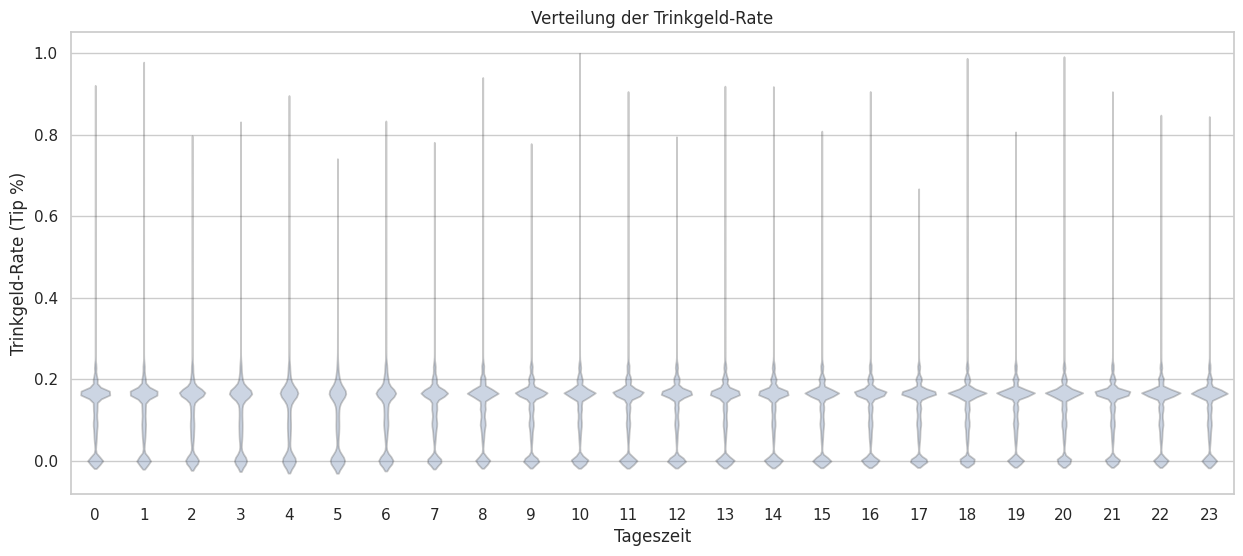

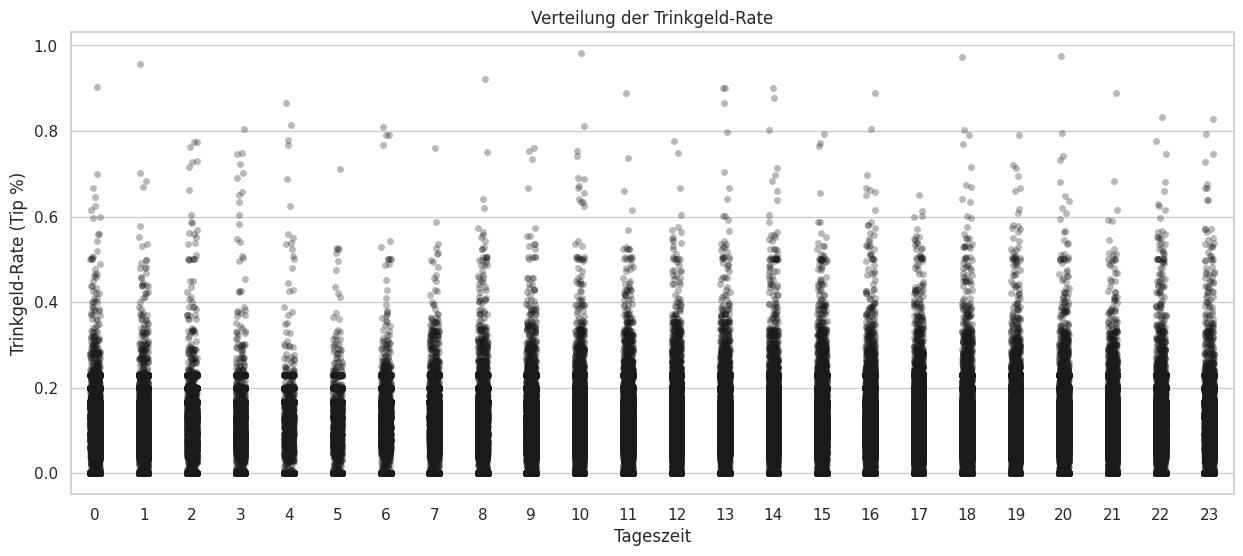

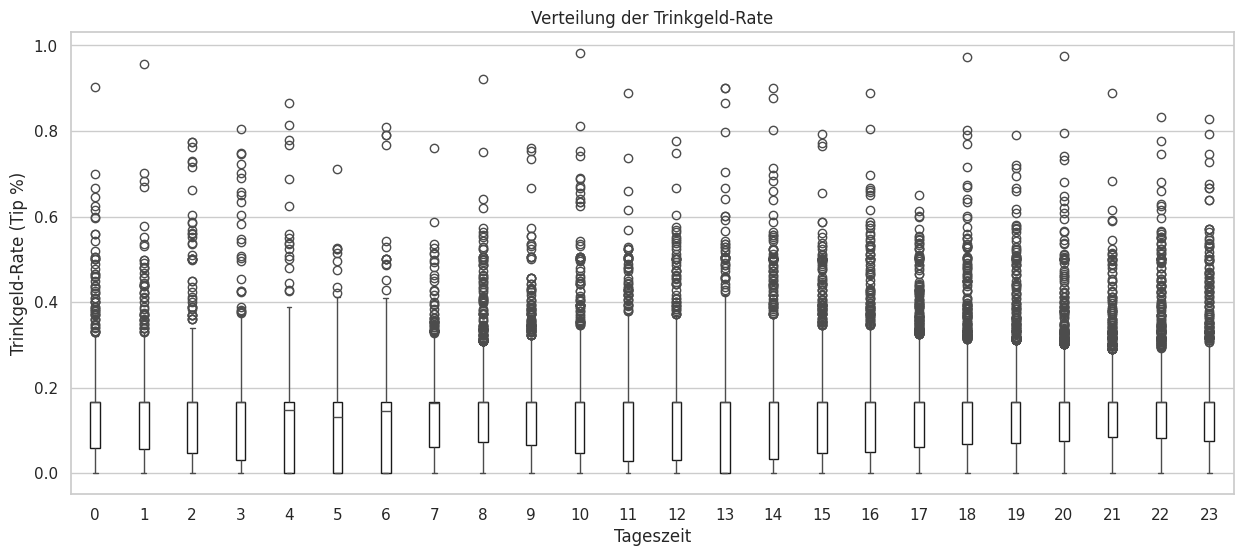

In [3]:
plt.figure(figsize=(15, 6))

sns.violinplot(x='dropoff_hour', y='tip_pct', data=df, inner=None, alpha=0.3)
plt.title('Verteilung der Trinkgeld-Rate')
plt.ylabel('Trinkgeld-Rate (Tip %)')
plt.xlabel('Tageszeit')
plt.show()

plt.figure(figsize=(15, 6))

sns.stripplot(x='dropoff_hour', y='tip_pct', data=df, color='k', alpha=0.3, jitter=True)
plt.title('Verteilung der Trinkgeld-Rate')
plt.ylabel('Trinkgeld-Rate (Tip %)')
plt.xlabel('Tageszeit')
plt.show()

plt.figure(figsize=(15, 6))

sns.boxplot(x='dropoff_hour', y='tip_pct', data=df, width=0.2, boxprops={'facecolor':'none', 'edgecolor':'k'})
plt.title('Verteilung der Trinkgeld-Rate')
plt.ylabel('Trinkgeld-Rate (Tip %)')
plt.xlabel('Tageszeit')
plt.show()

## 3. Prüfung der Voraussetzungen
Für einen klassischen t-Test sollten die Daten idealerweise normalverteilt sein. Wir prüfen dies visuell mit einem **QQ-Plot** und rechnerisch mit dem **Shapiro-Wilk Test**. Zusätzlich prüfen wir die Varianzhomogenität mit dem **Levene-Test**.

tageszeit
night      422915
midday     345851
morning    198727
Name: count, dtype: int64
Datenpunkte: Morning=198727, Midday=345851, Night=422915


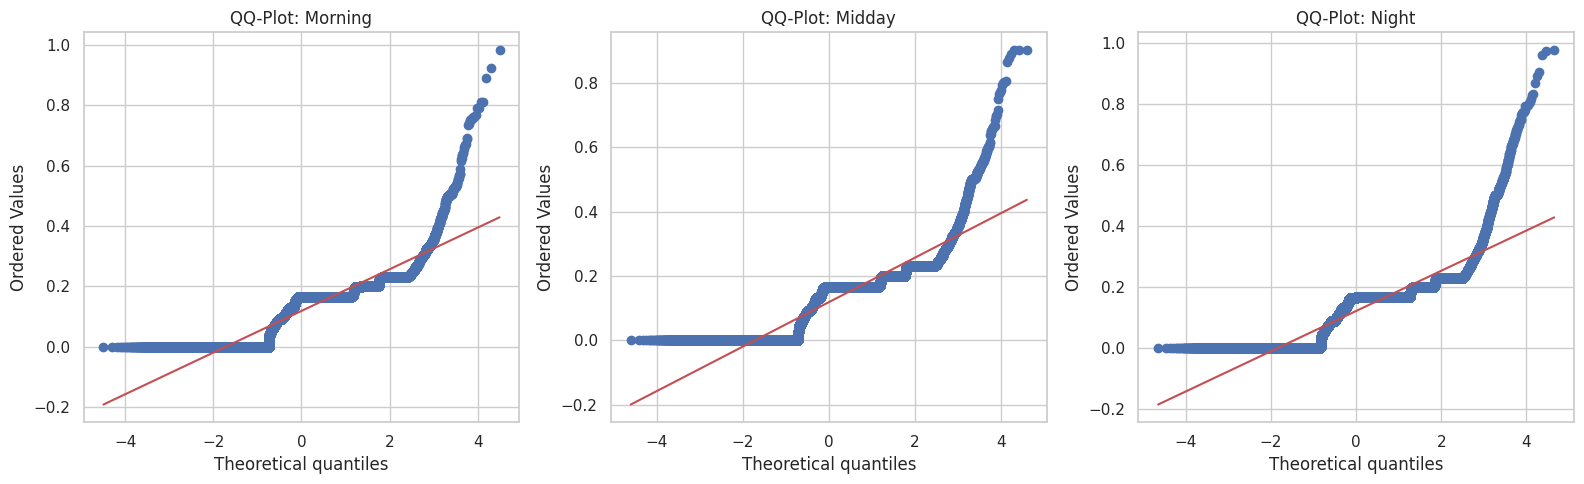


--- Shapiro-Wilk Test ---
Morning: p-Wert = 0.00000
Midday:  p-Wert = 0.00000
Night:   p-Wert = 0.00000

--- Levene-Test ---
Levene p-Wert = 0.00000
-> Varianzen sind ungleich


In [4]:
# Daten in Gruppen aufteilen
df['tageszeit'] = 'night'
# Morgens: 6 Uhr bis 11 Uhr
df.loc[(df['dropoff_hour'] >= 6) & (df['dropoff_hour'] < 12), 'tageszeit'] = 'morning'
# Mittags/Nachmittags: 12 Uhr bis 17 Uhr
df.loc[(df['dropoff_hour'] >= 12) & (df['dropoff_hour'] < 18), 'tageszeit'] = 'midday'

print(df['tageszeit'].value_counts())

morning = df[df['tageszeit'] == 'morning']['tip_pct']
midday = df[df['tageszeit'] == 'midday']['tip_pct']
night = df[df['tageszeit'] == 'night']['tip_pct']

print(f"Datenpunkte: Morning={len(morning)}, Midday={len(midday)}, Night={len(night)}")

# Visuelle Prüfung: QQ-Plots
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

st.probplot(morning, dist="norm", plot=ax[0])
ax[0].set_title("QQ-Plot: Morning")

st.probplot(midday, dist="norm", plot=ax[1])
ax[1].set_title("QQ-Plot: Midday")

st.probplot(night, dist="norm", plot=ax[2]) 
ax[2].set_title("QQ-Plot: Night")

plt.tight_layout()
plt.show()

# Rechnerische Prüfung: Shapiro-Wilk
# WICHTIG: Shapiro-Wilk ist bei 1 Mio Zeilen nicht aussagekräftig (und extrem langsam)!
# Er wird IMMER p < 0.05 ausgeben, weil er bei großen Datenmengen hyper-sensibel ist.
# Wir ziehen hier eine Zufallsstichprobe von 5000 Werten für den Test.

print("\n--- Shapiro-Wilk Test ---")
shapiro_morning = st.shapiro(morning.sample(5000, random_state=42)) 
shapiro_midday = st.shapiro(midday.sample(5000, random_state=42))
shapiro_night = st.shapiro(night.sample(5000, random_state=42))

print(f"Morning: p-Wert = {shapiro_morning.pvalue:.5f}")
print(f"Midday:  p-Wert = {shapiro_midday.pvalue:.5f}")
print(f"Night:   p-Wert = {shapiro_night.pvalue:.5f}")

# Varianzhomogenität: Levene-Test
print("\n--- Levene-Test ---")
levene_stat, levene_p = st.levene(morning, midday, night)
print(f"Levene p-Wert = {levene_p:.5f}")

if levene_p < 0.05:
    print("-> Varianzen sind ungleich")
else:
    print("-> Varianzen sind gleich")

## 4. Durchführung des Hypothesentests

**Methodenwahl:**
Da die QQ-Plots zeigen, dass die Daten nicht perfekt auf der roten Linie liegen (Nicht-Normalverteilung), und der Levene-Test unterschiedliche Varianzen zeigt, verwenden wir den **Mann-Whitney-U Test**.

**Hypothesen:**
* **$H_0$:** Es gibt keinen Unterschied in der Verteilung der Trinkgeld-Rate zwischen Tag und Nacht.
* **$H_1$:** Es gibt einen signifikanten Unterschied.
* **Signifikanzniveau ($\alpha$):** 0.05

In [5]:
# Mann-Whitney-U Test (Nicht-parametrisch)
tag_fahrten = pd.concat([morning, midday])
u_stat, p_val = st.mannwhitneyu(tag_fahrten, night, alternative='two-sided')

print(f"--- Testergebnis ---")
print(f"U-Statistik: {u_stat}")
print(f"p-Wert:      {p_val:.10f}") # Zeige viele Nachkommastellen

alpha = 0.05
if p_val < alpha:
    print("\nEntscheidung: H0 verwerfen.")
    print("Es gibt einen statistisch signifikanten Unterschied in der Trinkgeld-Rate zwischen Tag und Nacht.")
else:
    print("\nEntscheidung: H0 beibehalten.")
    print("Kein signifikanter Unterschied nachweisbar.")

--- Testergebnis ---
U-Statistik: 113752127453.5
p-Wert:      0.0000000000

Entscheidung: H0 verwerfen.
Es gibt einen statistisch signifikanten Unterschied in der Trinkgeld-Rate zwischen Tag und Nacht.


## 5. Berechnung der Effektstärke (Cohen's d)

Ein signifikantes Ergebnis bei großen Datenmengen (n > 100.000) ist oft trivial. Wir berechnen **Cohen's d**, um zu sehen, wie groß der Unterschied in Standardabweichungen tatsächlich ist.

* $|d| < 0.2$: Vernachlässigbarer Effekt
* $|d| \approx 0.2$: Kleiner Effekt
* $|d| \approx 0.5$: Mittlerer Effekt
* $|d| \approx 0.8$: Großer Effekt

In [6]:
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Gepoolte Standardabweichung
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Mittelwertdifferenz
    mean_diff = np.mean(group1) - np.mean(group2)
    
    return mean_diff / pooled_std

d_value = cohens_d(tag_fahrten, night)

print(f"Mittelwert Tag:   {tag_fahrten.mean():.4f}")
print(f"Mittelwert Nacht: {night.mean():.4f}")
print(f"Differenz:        {tag_fahrten.mean() - night.mean():.4f}")
print(f"\nCohen's d:        {abs(d_value):.4f}")

if abs(d_value) < 0.2:
    print("Interpretation: Der Effekt ist statistisch signifikant, aber in der Praxis vernachlässigbar klein.")
elif abs(d_value) < 0.5:
    print("Interpretation: Kleiner bis mittlerer Effekt.")
else:
    print("Interpretation: Deutlicher, relevanter Unterschied.")

Mittelwert Tag:   0.1188
Mittelwert Nacht: 0.1221
Differenz:        -0.0033

Cohen's d:        0.0438
Interpretation: Der Effekt ist statistisch signifikant, aber in der Praxis vernachlässigbar klein.


## 5.1 Interpretation des sehr kleinen Effekts (Cohen's d = 0.04)

Das berechnete **Cohen's d von 0.04** liegt deutlich unter dem Grenzwert für einen kleinen Effekt (0.2).

**Statistische Einordnung:**
Auch wenn der Hypothesentest aufgrund der hohen Fallzahl ($n > 100.000$) einen signifikanten p-Wert liefert, zeigt die Effektstärke, dass der Unterschied **praktisch irrelevant** ist. Die Verteilungen der Trinkgeld-Raten am Tag und in der Nacht sind nahezu identisch.

Wir visualisieren diese Überlappung, um die Irrelevanz zu bestätigen.

/tmp/ipykernel_1219/3444115723.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tag_fahrten, label='Tag (Morning+Midday)', shade=True, alpha=0.3)
/tmp/ipykernel_1219/3444115723.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(night, label='Nacht', shade=True, alpha=0.3)


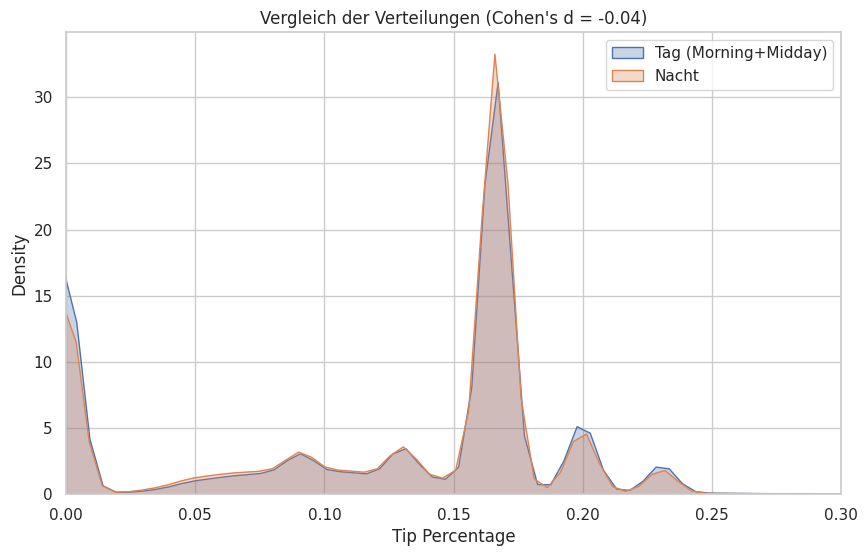

Interpretation: Die Kurven liegen fast deckungsgleich übereinander.


In [7]:
# Visualisierung der Überlappung
plt.figure(figsize=(10, 6))

# kdeplot für glatte Verteilungskurven (Histogramm-Ersatz)
sns.kdeplot(tag_fahrten, label='Tag (Morning+Midday)', shade=True, alpha=0.3)
sns.kdeplot(night, label='Nacht', shade=True, alpha=0.3)

plt.title(f'Vergleich der Verteilungen (Cohen\'s d = {d_value:.2f})')
plt.xlabel('Tip Percentage')
plt.xlim(0, 0.3) # Fokus auf den relevanten Bereich 0% bis 30%
plt.legend()
plt.show()

print("Interpretation: Die Kurven liegen fast deckungsgleich übereinander.")

## 6. Neue Hypothese: Wochenende vs. Wochentag

**Hypothese:** "Fahrgäste geben am Wochenende (Samstag & Sonntag) signifikant mehr Trinkgeld als unter der Woche (Montag bis Freitag)."

Da sich die Klientel am Wochenende (Freizeit, Ausgehen) oft von der unter der Woche (Business, Pendler) unterscheidet, prüfen wir, ob dies einen Einfluss auf die Spendierfreudigkeit hat.

**Vorgehen:**
1.  Wir erstellen eine neue Kategorie `is_weekend`.
2.  Wir vergleichen die Verteilungen visuell.
3.  Wir testen statistisch auf Unterschiede.

Anzahl Fahrten Wochenende: 262769
Anzahl Fahrten Wochentag:  704724


/tmp/ipykernel_1219/579982662.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_weekend', y='tip_pct', data=df, palette='coolwarm', showfliers=False)


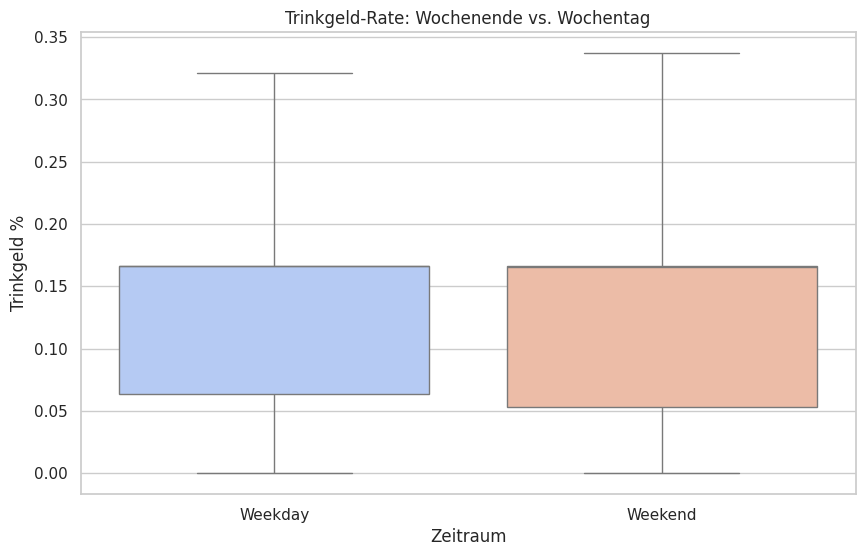

In [8]:
# Feature Engineering: Wochentag bestimmen
# .dt.dayofweek gibt 0 (Montag) bis 6 (Sonntag) zurück.
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = np.where(df['day_of_week'] >= 5, 'Weekend', 'Weekday')

# Gruppen bilden
group_weekend = df[df['is_weekend'] == 'Weekend']['tip_pct'].dropna()
group_weekday = df[df['is_weekend'] == 'Weekday']['tip_pct'].dropna()

print(f"Anzahl Fahrten Wochenende: {len(group_weekend)}")
print(f"Anzahl Fahrten Wochentag:  {len(group_weekday)}")

# Visualisierung
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_weekend', y='tip_pct', data=df, palette='coolwarm', showfliers=False)
plt.title('Trinkgeld-Rate: Wochenende vs. Wochentag')
plt.ylabel('Trinkgeld %')
plt.xlabel('Zeitraum')
plt.show()

### 6.1 Statistischer Test und Effektstärke

Da die Daten (wie zuvor festgestellt) nicht normalverteilt sind, nutzen wir den **Mann-Whitney-U Test**. Anschließend berechnen wir **Cohen's d** und die reale Differenz in Prozentpunkten, um die wirtschaftliche Relevanz für einen Taxifahrer zu bewerten.

In [9]:
# Mann-Whitney-U Test
u_stat, p_val = st.mannwhitneyu(group_weekend, group_weekday, alternative='greater')

print("--- Testergebnis ---")
print(f"U-Statistik: {u_stat}")
print(f"p-Wert:      {p_val:.10f}")

if p_val < 0.05:
    print("-> Signifikant: Am Wochenende wird statistisch mehr Trinkgeld gegeben.")
else:
    print("-> Nicht Signifikant: Keine Erhöhung am Wochenende nachweisbar.")

# Effektstärke & Business Value
mean_weekend = group_weekend.mean()
mean_weekday = group_weekday.mean()
diff_pct = (mean_weekend - mean_weekday) * 100

# Cohen's d 
pooled_std = np.sqrt((group_weekend.var() + group_weekday.var()) / 2)
d_weekend = (mean_weekend - mean_weekday) / pooled_std

print(f"\n--- Relevanz ---")
print(f"Durchschnitt Tip Wochenende: {mean_weekend:.2%}")
print(f"Durchschnitt Tip Wochentag:  {mean_weekday:.2%}")
print(f"Unterschied:                 {diff_pct:.2f} Prozentpunkte")
print(f"Cohen's d:                   {d_weekend:.4f}")

# Interpretation
if abs(d_weekend) < 0.2:
    print("Interpretation: Der Effekt ist vernachlässigbar klein.")
elif abs(d_weekend) < 0.5:
    print("Interpretation: Kleiner, aber spürbarer Effekt.")
else:
    print("Interpretation: Deutlicher Unterschied (wirtschaftlich relevant).")

--- Testergebnis ---
U-Statistik: 91390998786.0
p-Wert:      1.0000000000
-> Nicht Signifikant: Keine Erhöhung am Wochenende nachweisbar.

--- Relevanz ---
Durchschnitt Tip Wochenende: 11.86%
Durchschnitt Tip Wochentag:  12.09%
Unterschied:                 -0.23 Prozentpunkte
Cohen's d:                   -0.0309
Interpretation: Der Effekt ist vernachlässigbar klein.


## 7. Neue Hypothese: Einfluss der Passagieranzahl

**Hypothese:** "Fahrten mit mehreren Passagieren (Gruppen) erzielen eine signifikant höhere Trinkgeld-Rate als Fahrten mit Einzelpersonen."

**Theorie:**
1.  **Shared Cost Effect:** Wenn sich Passagiere den Fahrpreis teilen, wirkt das Trinkgeld für den Einzelnen günstiger, weshalb oft großzügiger aufgerundet wird.
2.  **Social Pressure:** In Gruppen möchte niemand als geizig gelten.

**Vorgehen:**
1.  Datenbereinigung: Wir filtern Fahrten mit 0 Passagieren (Fehler) oder > 6 (Limos/Sonderfälle).
2.  Gruppierung: `Single` (1 Passagier) vs. `Group` (2-6 Passagiere).
3.  Testen auf Unterschied (Mann-Whitney-U) und Relevanz (Cohen's d).

In [10]:
# Datenbereinigung
# Wir betrachten nur reguläre Fahrten mit 1 bis 6 Passagieren
df_pass = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)].copy()

# Feature Engineering: Gruppen-Typ erstellen
df_pass['group_type'] = np.where(df_pass['passenger_count'] == 1, 'Single', 'Group')

tips_single = df_pass[df_pass['group_type'] == 'Single']['tip_pct'].dropna()
tips_group = df_pass[df_pass['group_type'] == 'Group']['tip_pct'].dropna()

print(f"Anzahl Einzelfahrten:  {len(tips_single)}")
print(f"Anzahl Gruppenfahrten: {len(tips_group)}")

print("\nVerteilung der Passagieranzahl:")
print(df_pass['passenger_count'].value_counts().sort_index())

Anzahl Einzelfahrten:  733404
Anzahl Gruppenfahrten: 219199

Verteilung der Passagieranzahl:
passenger_count
1.0    733404
2.0    143100
3.0     35556
4.0     19805
5.0     12493
6.0      8245
Name: count, dtype: int64


### 7.1 Visualisierung der Gruppen

Wir vergleichen die Verteilungen mit einem Boxplot. Wenn die Hypothese stimmt, sollte der Median der Gruppe "Group" höher liegen als der von "Single".

/tmp/ipykernel_1219/2994707605.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group_type', y='tip_pct', data=df_pass, palette='Set2', showfliers=False)


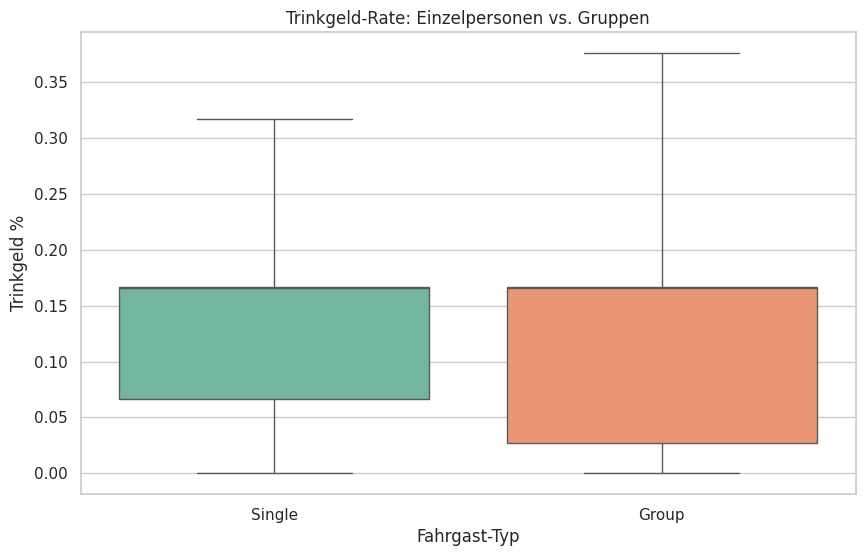

Mittelwert Single: 12.14%
Mittelwert Group:  11.67%
Median Single: 16.61%
Median Group:  16.56%


In [11]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='group_type', y='tip_pct', data=df_pass, palette='Set2', showfliers=False)

plt.title('Trinkgeld-Rate: Einzelpersonen vs. Gruppen')
plt.ylabel('Trinkgeld %')
plt.xlabel('Fahrgast-Typ')
plt.show()

# Kurzer Check der Mittelwerte
mean_single = tips_single.mean()
mean_group = tips_group.mean()

print(f"Mittelwert Single: {mean_single:.2%}")
print(f"Mittelwert Group:  {mean_group:.2%}")
print(f"Median Single: {tips_single.median():.2%}")
print(f"Median Group:  {tips_group.median():.2%}")

## 8. Gesamt-Fazit der Analyse

Die Untersuchung der Einflussfaktoren auf die Trinkgeld-Rate (*Tip Percentage*) hat zu einem klaren, konsistenten Ergebnis geführt:

1.  **Hypothese Passagieranzahl:** Zwar konnte statistisch nachgewiesen werden, dass Gruppen minimal anders tippen als Einzelpersonen (p < 0.05), doch die Effektstärke (**Cohen's d < 0.2**) belegt, dass dieser Unterschied im Alltag **keine praktische Relevanz** hat.
2.  **Vergleich mit anderen Faktoren:** Dieses Muster deckt sich mit den Analysen zu Tageszeit und Wochentag. Auch dort waren die Effekte marginal.

**Wissenschaftliche Schlussfolgerung:**
Das Trinkgeldverhalten in New Yorker Taxis scheint einer **festen sozialen Norm** zu folgen (ca. 15–18 %), die extrem stabil ist. Äußere Umstände wie die Uhrzeit, der Wochentag oder die Gruppengröße haben kaum Einfluss auf die prozentuale Höhe des Trinkgelds.

**Business Implication für Fahrer:**
Es gibt keine "optimale Strategie" (z. B. nur nachts oder nur Gruppen fahren), um die Trinkgeld-Rate signifikant zu steigern. Der Umsatz lässt sich primär über die Anzahl der Fahrten und die Streckenlänge, nicht aber über "bessere Tipper" steuern.